### Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [2]:
import datetime
import datetime as dt
from datetime import timedelta
import csv

In [3]:
# ARIMA and SARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random

### Read/Load

In [4]:
deliveries = pd.read_csv('deliveries.csv')
orders = pd.read_csv('orders.csv')
stores = pd.read_csv('stores.csv')

### View rows from the beginning and at the end

In [5]:
deliveries.head(3)

,store_id,month,deliveryTracked,deliveryLate,deliveryTime
0,8392,2012-04-28,334,153,21743
1,8125,2012-06-28,899,180,37149
2,8330,2012-03-29,164,70,8264


In [6]:
deliveries['month'].value_counts()

2012-06-28    473
2012-05-29    471
2012-04-28    466
2012-03-29    457
Name: month, dtype: int64

In [7]:
orders.head(3)

,id,date,order_channel,estimated_time,refund_total,customer_id,cost_total,store_id,status,delivery_latitude,delivery_longitude,checkout
0,2320560,2012-04-09 21:17:44,website,22:20 09-04-12,0.0,167606,53.2667,8080,1,55.739000,-4.776250,1
1,2432636,2012-04-27 07:22:06,android,11:00 27-04-12,0.0,174915,51.6924,8948,1,53.708032,-1.350555,1
2,2710926,2012-06-05 16:00:27,android,17:00 05-06-12,0.0,166251,35.9840,8432,1,52.382900,-0.702041,1


In [8]:
stores.head(3)

,id,name,date_live,latitude,longitude,menu_group_id,menu_items
0,8028,store no. 8028,2011-02-01,55.877075,-3.984258,5752,11260
1,8432,store no. 8432,2011-05-27,52.383146,-0.697325,6069,15376
2,8121,store no. 8121,2012-02-22,50.801827,-3.450466,6070,2216


### select the orders that have been checked out

In [9]:
comp_order = orders.loc[(orders['checkout'] == 1)]
comp_order.head(3)

,id,date,order_channel,estimated_time,refund_total,customer_id,cost_total,store_id,status,delivery_latitude,delivery_longitude,checkout
0,2320560,2012-04-09 21:17:44,website,22:20 09-04-12,0.0,167606,53.2667,8080,1,55.739000,-4.776250,1
1,2432636,2012-04-27 07:22:06,android,11:00 27-04-12,0.0,174915,51.6924,8948,1,53.708032,-1.350555,1
2,2710926,2012-06-05 16:00:27,android,17:00 05-06-12,0.0,166251,35.9840,8432,1,52.382900,-0.702041,1


In [10]:
comp_order[['date','time']] = comp_order['date'].str.split(' ', expand=True)
comp_order.head(3)

,id,date,order_channel,estimated_time,refund_total,customer_id,cost_total,store_id,status,delivery_latitude,delivery_longitude,checkout,time
0,2320560,2012-04-09,website,22:20 09-04-12,0.0,167606,53.2667,8080,1,55.739000,-4.776250,1,21:17:44
1,2432636,2012-04-27,android,11:00 27-04-12,0.0,174915,51.6924,8948,1,53.708032,-1.350555,1,07:22:06
2,2710926,2012-06-05,android,17:00 05-06-12,0.0,166251,35.9840,8432,1,52.382900,-0.702041,1,16:00:27


### sort the order date

In [11]:
date_order = comp_order.sort_values(by="date")
date_order.head(3)

,id,date,order_channel,estimated_time,refund_total,customer_id,cost_total,store_id,status,delivery_latitude,delivery_longitude,checkout,time
6348,2235385,2012-03-29,android,14:10 29-03-12,0.0,163962,46.8311,8981,1,56.053498,-3.949819,1,13:09:31
44377,2236627,2012-03-29,android,16:20 29-03-12,0.0,164032,86.8114,8075,1,51.429100,0.729251,1,15:17:56
47549,2239507,2012-03-29,ios,20:30 29-03-12,0.0,164181,39.4959,8471,1,56.040047,-3.087979,1,19:45:08


#### one column holding every dates when the orders were completed and one column holding the counts of orders

In [12]:
date_order2 = date_order.groupby(['date'])['time'].agg('count').reset_index()
display(date_order2)

,date,time
0,2012-03-29,396
1,2012-03-30,575
2,2012-03-31,673
3,2012-04-01,577
4,2012-04-02,447
...,...,...
117,2012-07-24,319
118,2012-07-25,292
119,2012-07-26,296
120,2012-07-27,385


In [13]:
#find the type of data
type(date_order2)

pandas.core.frame.DataFrame

#### rename the column to no_of_orders

In [14]:
date_order2 = date_order2.rename(columns = {'time':'no_of_orders'})
display(date_order2)

,date,no_of_orders
0,2012-03-29,396
1,2012-03-30,575
2,2012-03-31,673
3,2012-04-01,577
4,2012-04-02,447
...,...,...
117,2012-07-24,319
118,2012-07-25,292
119,2012-07-26,296
120,2012-07-27,385


### Duration of dataset

In [15]:
def orders_duration(data):
    data.date = pd.to_datetime(data.date)
    number_of_days = data.date.max() - data.date.min()
    number_of_weeks = number_of_days.days / 7
    print(number_of_days.days, 'days')
    print(number_of_weeks, 'weeks')
    
orders_duration(date_order2)

121 days
17.285714285714285 weeks


#### setting the date in the index column

In [16]:
date_order2_1 = pd.DataFrame(date_order2)
date_order2_1["date"] = pd.to_datetime(date_order2_1["date"])
date_order2_1.set_index('date', inplace=True)

In [17]:
date_order2_2 = date_order2_1.resample('w').sum()

In [18]:
date_order2_3 = date_order2_1.resample('w').mean()

In [19]:
y = date_order2_3.no_of_orders
y = y.to_frame()
y

,no_of_orders
date,
2012-04-01,555.250000
2012-04-08,535.428571
2012-04-15,562.285714
2012-04-22,606.571429
2012-04-29,612.000000
2012-05-06,444.857143
2012-05-13,385.285714
2012-05-20,359.571429
2012-05-27,377.857143


#### descriptive statistics

In [31]:
y.describe()

,no_of_orders
count,18.000000
mean,415.982143
std,106.090237
min,319.714286
25%,337.285714
50%,361.500000
75%,512.785714
max,612.000000


#### Plots to observe the monthly and weekly patterns

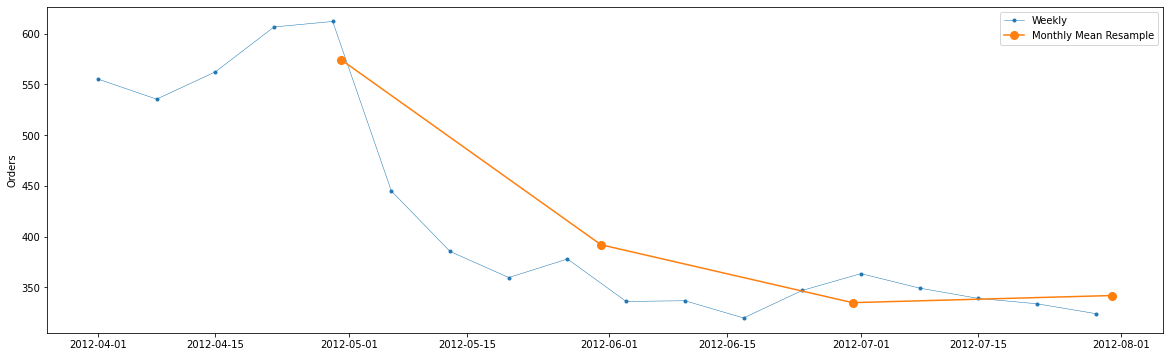

In [20]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Orders')
ax.legend();

### Stationarity

In [21]:
def get_diff(data):
    data['orders_diff'] = data.no_of_orders.diff()
    data = data.dropna()
    
    return data

In [22]:
stationary_df = get_diff(y)

In [23]:
stationary_df

,no_of_orders,orders_diff
date,,
2012-04-08,535.428571,-19.821429
2012-04-15,562.285714,26.857143
2012-04-22,606.571429,44.285714
2012-04-29,612.000000,5.428571
2012-05-06,444.857143,-167.142857
2012-05-13,385.285714,-59.571429
2012-05-20,359.571429,-25.714286
2012-05-27,377.857143,18.285714
2012-06-03,336.000000,-41.857143


In [24]:
#Remove the dates as the index
date_order3_1 = stationary_df.reset_index(level='date')

## Preparing Dataset Modeling

### Regressive Modeling

In [25]:
#function to create dataframe for transformation from time series to supervised
def generate_supervised(data):
    supervised_df = data.copy()
    
    #create column for each lag
    for i in range(1,13):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['orders_diff'].shift(i)
    
    return supervised_df

In [26]:
#create the dataframe
model_df = generate_supervised(stationary_df)

In [27]:
#Replace the "NaN" with 0
model_df = model_df.fillna(0)

In [28]:
model_df.head(3)

,no_of_orders,orders_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
date,,,,,,,,,,,,,,
2012-04-08,535.428571,-19.821429,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-04-15,562.285714,26.857143,-19.821429,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-04-22,606.571429,44.285714,26.857143,-19.821429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### ARIMA MODELLING

In [29]:
def generate_arima_data(data):
    dt_data = data.set_index('date').drop('no_of_orders', axis=1)
    
    dt_data.to_csv('./arima_df.csv')
    return dt_data

In [30]:
datetime_df = generate_arima_data(date_order3_1)

In [31]:
datetime_df

,orders_diff
date,
2012-04-08,-19.821429
2012-04-15,26.857143
2012-04-22,44.285714
2012-04-29,5.428571
2012-05-06,-167.142857
2012-05-13,-59.571429
2012-05-20,-25.714286
2012-05-27,18.285714
2012-06-03,-41.857143


### ARIMA in a simple way to form a summary of Results and Predict tbe next week's Order

In [32]:
model=ARIMA(model_df['no_of_orders'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           no_of_orders   No. Observations:                   17
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -84.329
Date:                Fri, 31 Dec 2021   AIC                            174.657
Time:                        16:22:22   BIC                            176.975
Sample:                    04-08-2012   HQIC                           174.776
                         - 07-29-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0970      2.467      0.039      0.969      -4.738       4.932
ma.L1          0.1968      2.271      0.087      0.931      -4.254       4.648
sigma2      2204.3413    742.781      2.968      0.003     748.517    3660.166
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                35.78
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.02   Skew:                            -2.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
# make prediction for the next week's mean orders

week_no = [0,1,2]

yhat = []
for i in week_no:
    yhat_each = model_fit.predict(len(model_df)+i, len(model_df)+i, typ='levels')
    yhat.append(yhat_each)

In [34]:
yhat

[2012-08-05    321.372844
 Freq: W-SUN, dtype: float64,
 2012-08-12    321.117945
 Freq: W-SUN, dtype: float64,
 2012-08-19    321.093214
 Freq: W-SUN, dtype: float64]

### Reference: Molly Liebeskind's GitHub and medium.com